In [41]:
import pandas as pd
import numpy as np
np.random.seed(42)
n = 1000
data = {
    "Salary" :np.random.randint(30000,120000,n),
    
    "Department":np.random.choice(["HR","IT","Sales","Marketing","Finance"],n),
    "JobSatisfaction":np.random.randint(1,6,n),
    "PerformanceScore" : np.random.randint(1,11,n),
    "LeftCompany": np.random.choice([0,1],n,p=[0.7,0.3]) #70% stayed,30%left
    
}

df =pd.DataFrame(data)
print(df.head(5))

   Salary Department  JobSatisfaction  PerformanceScore  LeftCompany
0   45795      Sales                1                 1            0
1   30860    Finance                4                 8            1
2  106820    Finance                3                 3            1
3   84886    Finance                3                 8            0
4   36265      Sales                4                 8            0


# Data Analysis

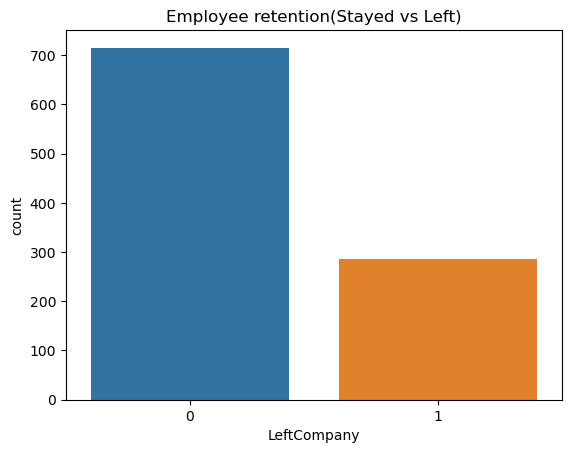

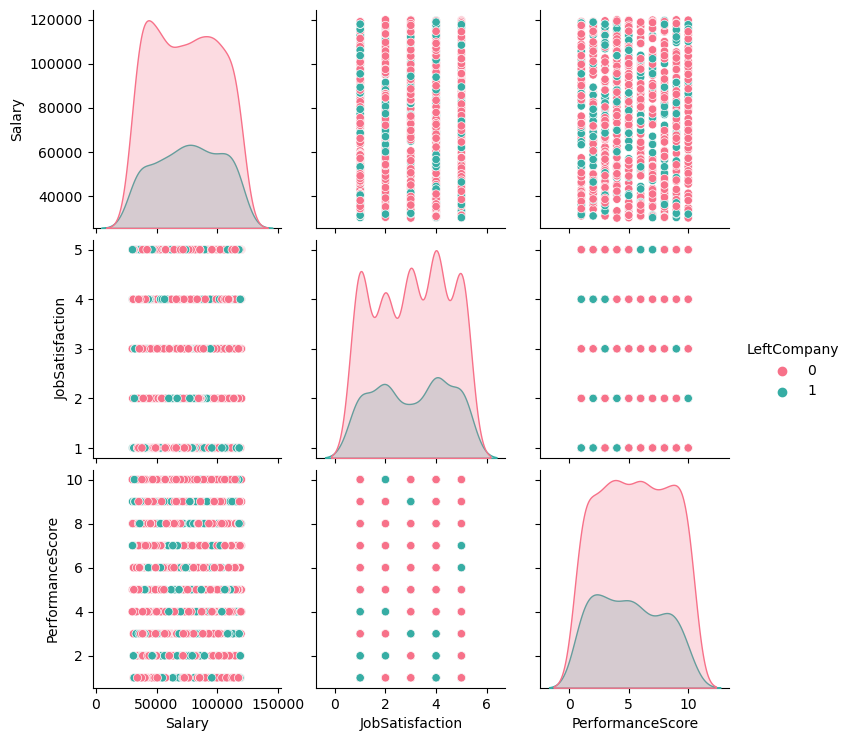

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

#class distrubution check
sns.countplot(x="LeftCompany", data=df)
plt.title('Employee retention(Stayed vs Left)')
plt.show()

sns.pairplot(df,hue="LeftCompany", diag_kind="kde", palette="husl")
plt.show()


# preprocessing

# Build Model

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Splitting the dataset
X = df.drop("LeftCompany", axis=1)
y = df["LeftCompany"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numerical_features = ["Salary", "JobSatisfaction", "PerformanceScore"]
categorical_features = ["Department"]

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.64
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.82      0.77       146
           1       0.25      0.17      0.20        54

    accuracy                           0.64       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.60      0.64      0.61       200



# Tune model

In [46]:
from sklearn.model_selection import GridSearchCV

# Define Parameter Grid
param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],  # Corrected typo
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Best Parameters: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 100}
Best Cross-Validation Accuracy: 0.6987740887800026


# Visualize

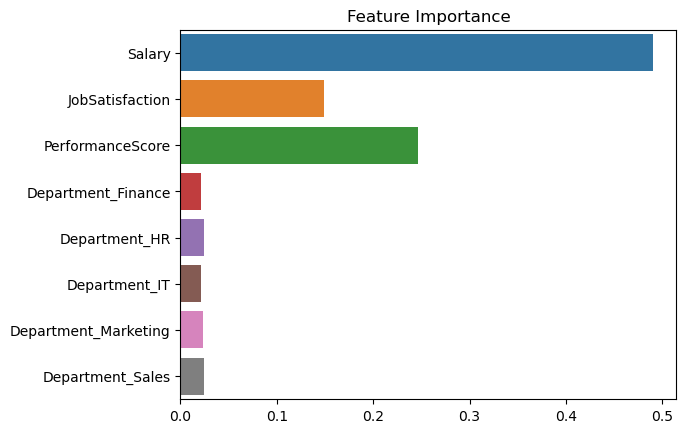

In [47]:
importances = grid_search.best_estimator_.named_steps["model"].feature_importances_

feature_names = numerical_features + list(grid_search.best_estimator_.named_steps["preprocessor"].named_transformers_["cat"].get_feature_names_out())
sns.barplot(x=importances,y=feature_names)
plt.title("Feature Importance")
plt.show()

In [48]:
import joblib
joblib.dump(grid_search.best_estimator_,'employee_retention_model.pkl')

['employee_retention_model.pkl']